In [ ]:
!pip install pyyaml==5.1
!pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html

In [1]:
import torch
assert torch.__version__.startswith("1.8") 
import torchvision
import cv2
import os
import numpy as np
import json
import random
import matplotlib.pyplot as plt
%matplotlib inline

from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog

In [2]:
def get_data_dicts(directory, classes):
    dataset_dicts = []
    for filename in [file for file in os.listdir(directory) if file.endswith('.json')]:
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            img_anns = json.load(f)

        record = {}
        
        filename = os.path.join(directory, img_anns["imagePath"])
        
        record["file_name"] = filename
        record["height"] = 500
        record["width"] = 850
      
        annos = img_anns["shapes"]
        objs = []
        for anno in annos:
            px = [a[0] for a in anno['points']] # x coord
            py = [a[1] for a in anno['points']] # y-coord
            poly = [(x, y) for x, y in zip(px, py)] # poly for segmentation
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(anno['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [3]:

classes = ['car', 'auto','motorbike','building','bridge','truck','person','bus','traffic light','stop sign']
classes.sort()
print(classes)
colors = [(255,255,255),(255,255,85),(170,170,255),(85,255,85),(85,255,255),(255,51,255),(204,102,255),(51,255,253),(255,102,0),(153,51,240)]


['auto', 'bridge', 'building', 'bus', 'car', 'motorbike', 'person', 'stop sign', 'traffic light', 'truck']


In [42]:

data_path = '/content/drive/MyDrive/DATAA/'

for d in ["train", "test"]:
    DatasetCatalog.register(
        "category_" + d, 
        lambda d=d: get_data_dicts(data_path+d, classes)
    )
    print(d)
    #print(get_data_dicts(data_path + d, classes))
    MetadataCatalog.get("category_" + d).set(thing_classes=classes)
    MetadataCatalog.get("category_" + d).set(thing_colors = colors)
microcontroller_metadata = MetadataCatalog.get("category_train")

train
test


In [ ]:
DatasetCatalog.remove("category_test")
DatasetCatalog.remove("category_train")

#print(microcontroller_metadata)
# print(type("category_train"))

In [64]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode, Visualizer
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("category_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 600
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 10

In [ ]:
!nvidia-smi

#Training

In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
print(cfg.OUTPUT_DIR)

In [66]:
trainer.train()

[12/05 16:58:50 d2.engine.train_loop]: Starting training from iteration 0
[12/05 16:59:26 d2.utils.events]:  eta: 0:18:04  iter: 19  total_loss: 3.973  loss_cls: 2.519  loss_box_reg: 0.5759  loss_mask: 0.692  loss_rpn_cls: 0.1059  loss_rpn_loc: 0.0441  time: 1.8015  data_time: 0.0210  lr: 8.1588e-06  max_mem: 3630M
[12/05 17:00:02 d2.utils.events]:  eta: 0:16:58  iter: 39  total_loss: 3.801  loss_cls: 2.349  loss_box_reg: 0.6237  loss_mask: 0.6864  loss_rpn_cls: 0.1084  loss_rpn_loc: 0.06097  time: 1.7891  data_time: 0.0109  lr: 1.6484e-05  max_mem: 3657M
[12/05 17:00:38 d2.utils.events]:  eta: 0:16:26  iter: 59  total_loss: 3.466  loss_cls: 1.995  loss_box_reg: 0.6494  loss_mask: 0.6749  loss_rpn_cls: 0.1209  loss_rpn_loc: 0.05451  time: 1.7913  data_time: 0.0104  lr: 2.4809e-05  max_mem: 3730M
[12/05 17:01:13 d2.utils.events]:  eta: 0:15:34  iter: 79  total_loss: 2.862  loss_cls: 1.477  loss_box_reg: 0.6004  loss_mask: 0.6588  loss_rpn_cls: 0.06926  loss_rpn_loc: 0.04786  time: 1.778

In [67]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
cfg.DATASETS.TEST = ("category_test", )
predictor = DefaultPredictor(cfg)

#Prediction


In [160]:
#test with an image
pathh = '/content/drive/MyDrive/DATAA/train/'
img = cv2.imread(pathh+'455.jpg')
img.shape

(500, 850, 3)

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


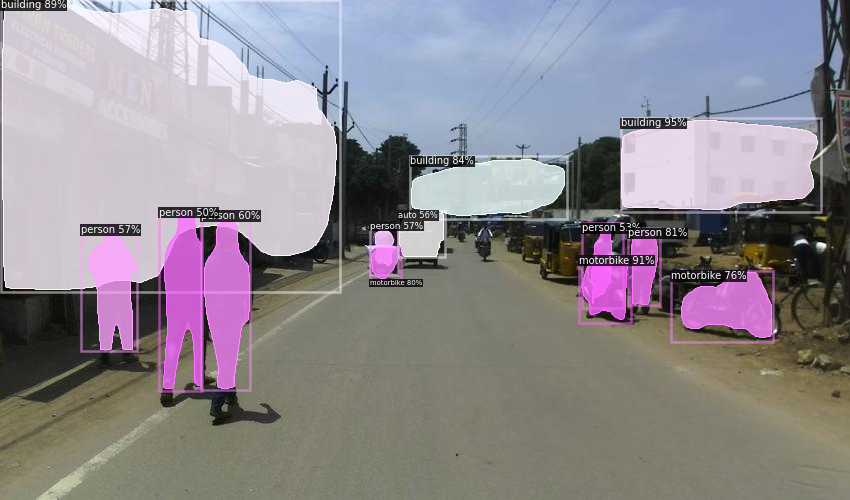

In [161]:
import numpy as np
from google.colab.patches import cv2_imshow
wall = np.zeros(img.shape)
outputs = predictor(img)
v = Visualizer(img[:, :, ::-1],
               metadata=microcontroller_metadata, 
                 scale=1, 
                 instance_mode=ColorMode.SEGMENTATION # removes the colors of unsegmented pixels
  )
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
img = v.get_image()[:,:,::-1]
pred_image
cv2_imshow(v.get_image()[:,:,::-1])

In [162]:
classes_detected = outputs['instances'].pred_classes
print(classes_detected)
print(classes)

tensor([2, 5, 2, 2, 6, 5, 5, 6, 6, 6, 0, 6, 6], device='cuda:0')
['auto', 'bridge', 'building', 'bus', 'car', 'motorbike', 'person', 'stop sign', 'traffic light', 'truck']


In [163]:
dic ={}
classes_detected = classes_detected.tolist()
set_detected = list(set(classes_detected))
print(set_detected)
for i in range(len(set_detected)):
  dic[set_detected[i]] = []
dic

[0, 2, 5, 6]


{0: [], 2: [], 5: [], 6: []}

In [164]:
def get_partitions(img,dim):
  dims = [3,4,5,6]
  partitions = []
  for i in range(len(dims)):
    if dim%dims[i]==0:
      division = dims[i]
      gap = dim//dims[i]
      for j in range(dims[i]+1):
        partitions.append(gap*j)
      partitions[-1]-=1
      return partitions,division
print(get_partitions(img,500))
print(get_partitions(img,850))

([0, 125, 250, 375, 499], 4)
([0, 170, 340, 510, 680, 849], 5)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


(20,)


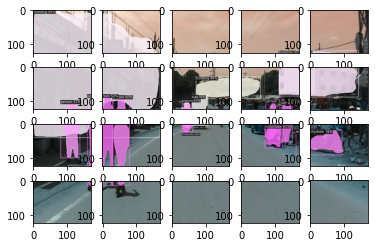

In [165]:
import cv2
def img2grid(img):
  h, w, channels = img.shape
  x,rows = get_partitions(img,h)
  y,columns = get_partitions(img,w)
  #plt.imshow(img)
  grid = []
  for i in range(len(x)-1):
    for j in range(len(y)-1):
      grid.append( img[x[i]:x[i+1], y[j]:y[j+1]])
  grid = np.array(grid)
  return grid,rows,columns


grid_no=0
grid,rows,columns = img2grid(img)
print(grid.shape)
for i in range(rows):
  for j in range(columns):
    plt.subplot(rows,columns,grid_no+1)
    plt.imshow(grid[grid_no])
    grid_no+=1
plt.show()

In [166]:
#create bianry mask
mask_array = outputs['instances'].pred_masks.to('cpu').numpy()
print(mask_array.shape)
mask_array = np.moveaxis(mask_array, 0, -1)
print(mask_array.shape)
mask_array_instance = []
output = np.zeros_like(img) #black
print(output.shape)

(13, 500, 850)
(500, 850, 13)
(500, 850, 3)


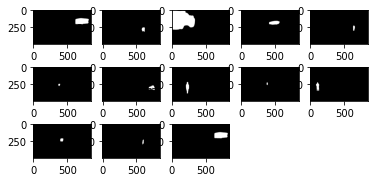

In [172]:
for i in range(len(classes_detected)):
  output = np.zeros_like(img) #black
  plt.subplot(rows,columns,i+1)
  mask_array_instance.append(mask_array[:, :, i:(i+1)])
  plt.imshow(np.where(mask_array_instance[i] == True, 255, output))


plt.imshow(np.where(mask_array_instance[0] == True, 255, output))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


{0: [7, 12, 7, 12, 7, 12, 7, 12], 2: [3, 4, 8, 9, 0, 1, 5, 6, 10, 11, 7, 8, 3, 4, 8, 9, 0, 1, 5, 6, 10, 11, 7, 8, 3, 4, 8, 9, 0, 1, 5, 6, 10, 11, 7, 8, 3, 4, 8, 9, 0, 1, 5, 6, 10, 11, 7, 8], 5: [13, 7, 12, 14, 13, 7, 12, 14, 13, 7, 12, 14, 13, 7, 12, 14], 6: [8, 13, 6, 11, 16, 7, 12, 5, 10, 8, 13, 3, 4, 8, 9, 8, 13, 6, 11, 16, 7, 12, 5, 10, 8, 13, 3, 4, 8, 9, 8, 13, 6, 11, 16, 7, 12, 5, 10, 8, 13, 3, 4, 8, 9, 8, 13, 6, 11, 16, 7, 12, 5, 10, 8, 13, 3, 4, 8, 9]}
{'auto': [12, 7], 'building': [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11], 'motorbike': [12, 13, 14, 7], 'person': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16]}
(20,)


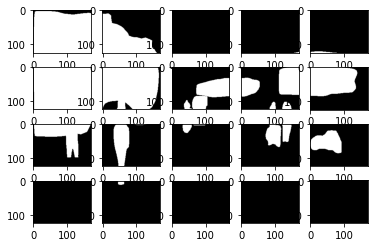

In [178]:
complete_img = np.zeros_like(img)
for i in range(len(classes_detected)):
  output = np.zeros_like(img) #black
  complete_img = np.where(mask_array_instance[i] == True, 255, complete_img)

  mask_array_instance.append(mask_array[:, :, i:(i+1)])
  
  output = np.where(mask_array_instance[i] == True, 255, output)
  
  grids_array,rows,columns = img2grid(output)
   # plt.imshow(grid_array[0])
  grid = grids_array
  grid_no=0
  total_area = columns*rows
  for x in range(rows):
    for y in range(columns):

        #converting 3d image to 2d grayscale
      grids_array[grid_no] = grids_array[grid_no][:,:,0]
        #2d to 1d 
      flat_list = list(grids_array[grid_no].flatten())

      count = flat_list.count(255.0)
      if (count/total_area)>0.2:
        dic[classes_detected[i]].append(grid_no)
      grid_no+=1
        #break
print(dic)
result = {}
for clas in dic.keys():
  result[classes[clas]] = list(set(dic[clas]))
print(result) 

grid_no=0
grid,rows,columns = img2grid(complete_img)
print(grid.shape)
for i in range(rows):
  for j in range(columns):
    plt.subplot(rows,columns,grid_no+1)
    plt.imshow(grid[grid_no])
    grid_no+=1
plt.show()


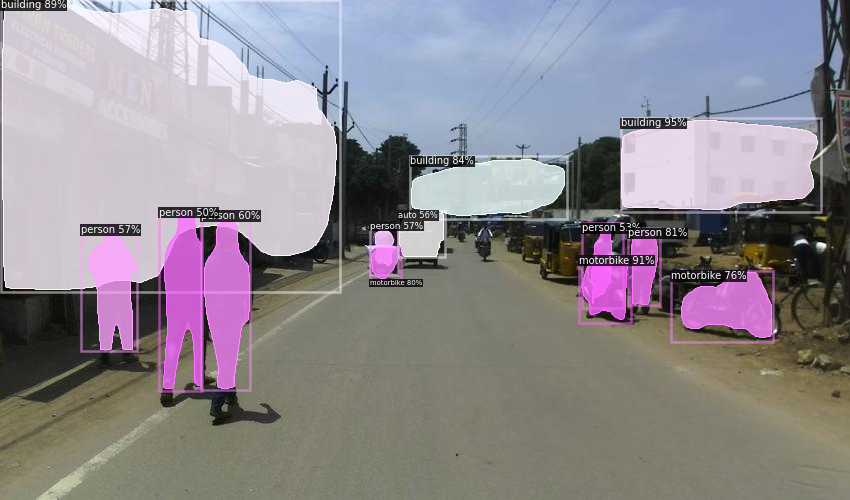

In [175]:
cv2_imshow(img)